In [5]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import autobet.ocr_model as ocr_model
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
NUMBER_FONT = ImageFont.truetype('fonts/ChaletLondonNineteenSixty.ttf', 20)
LETTER_FONT = ImageFont.truetype('fonts/ChaletNewYorkNineteenSixty.ttf', 15)
GENERATED_TRAIN_SIZE = 30_000
GENERATED_TEST_SIZE = 3_000
GENERATED_TRAIN_PATH = '/storage/gta/training_data/train_images'
GENERATED_TEST_PATH = '/storage/gta/training_data/test_images'
ACTUAL_TRAIN_PATH = 'training_data/odds'

BATCH_SIZE = 256

In [7]:
def generate_example(odd):
    rand_bg = random.randint(200, 255)
    img = Image.new('L', ocr_model.INPUT_SHAPE[:2], color=(rand_bg,))
    d = ImageDraw.Draw(img)
    rand_x = random.randint(0, 10)
    rand_y = random.randint(5, 15)
    rand_fg = random.randint(0, 55)
    if odd != 1:
        d.text((rand_x,rand_y), f'{odd}/1', font=NUMBER_FONT, fill=rand_fg)
    else:
        d.text((rand_x,rand_y), 'EVENS', font=LETTER_FONT, fill=rand_fg)
    return img

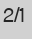

In [8]:
generate_example('2')

In [9]:
# Generate datasets
for path in [GENERATED_TRAIN_PATH, GENERATED_TEST_PATH]:
    for odd in range(30):
        Path(f'{path}/{odd}').mkdir(parents=True, exist_ok=True)

for odd in tqdm(range(30)):
    for i in tqdm(range(GENERATED_TRAIN_SIZE // 30), leave=False):
        example = generate_example(odd+1)
        example.save(f'{GENERATED_TRAIN_PATH}/{odd}/{i}.bmp')
    
for odd in tqdm(range(30)):
    for i in tqdm(range(GENERATED_TEST_SIZE // 30), leave=False):
        example = generate_example(odd+1)
        example.save(f'{GENERATED_TEST_PATH}/{odd}/{i}.bmp')

In [72]:
CLASS_LABELS = {str(i): i for i in range(30)}

gen_train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=30,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.5,1.5)
)

gen_train_dataset = gen_train_image_generator.flow_from_directory(
    GENERATED_TRAIN_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="grayscale",
    classes=CLASS_LABELS,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

actual_train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.3,
    brightness_range=(0.5,1.5)
)

actual_train_dataset = actual_train_image_generator.flow_from_directory(
    ACTUAL_TRAIN_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="grayscale",
    classes=CLASS_LABELS,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

actual_class_weights = compute_class_weight(
    'balanced',
    np.unique(actual_train_dataset.classes), 
    actual_train_dataset.classes
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

gen_test_dataset = test_image_generator.flow_from_directory(
    GENERATED_TEST_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="grayscale",
    classes=CLASS_LABELS,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

actual_test_dataset = test_image_generator.flow_from_directory(
    ACTUAL_TRAIN_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="grayscale",
    classes=CLASS_LABELS,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 30000 images belonging to 30 classes.
Found 362 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.
Found 362 images belonging to 30 classes.


In [73]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        plt.title(np.argmax(label_batch[n]))
        plt.axis('off')

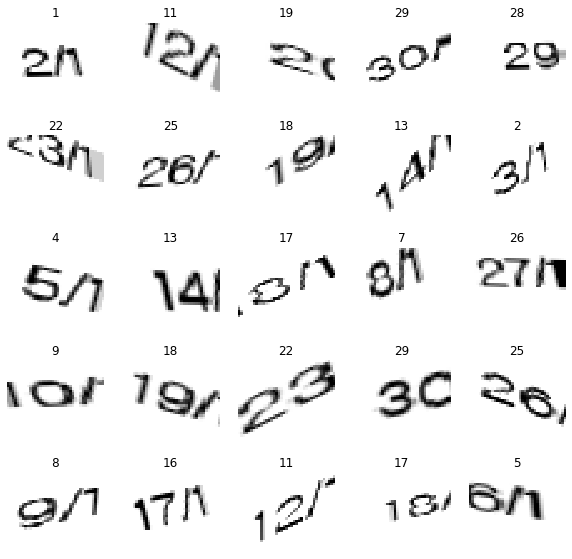

In [74]:
image_batch, label_batch = next(gen_train_dataset)
show_batch(np.squeeze(image_batch), label_batch)

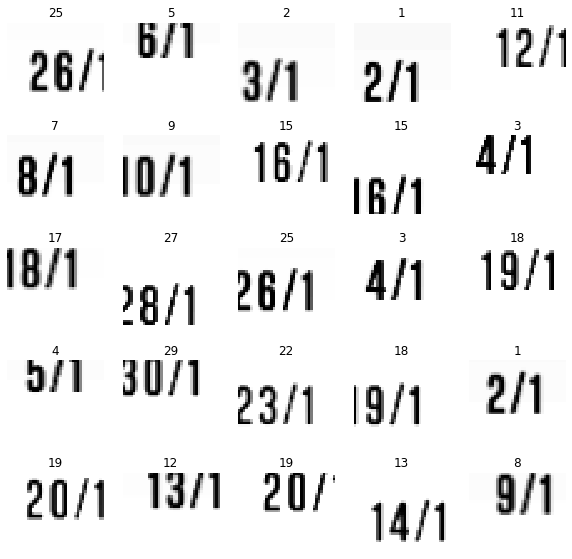

In [75]:
image_batch, label_batch = next(actual_train_dataset)
show_batch(np.squeeze(image_batch), label_batch)

In [76]:
model = ocr_model.load_model()
model.count_params()

2295838

In [93]:
model.fit_generator(gen_train_dataset, epochs=60, verbose=1)

Epoch 1/60
118/118 [==============================] - 78s 658ms/step - loss: 2.5792 - accuracy: 0.8778
Epoch 2/60
 42/118 [=========>....................] - ETA: 35s - loss: 2.5347 - accuracy: 0.9212

KeyboardInterrupt: 

In [94]:
model.evaluate_generator(gen_test_dataset, verbose=1)

12/12 [==============================] - 5s 414ms/step - loss: 2.5214 - accuracy: 0.9353


[2.5214391549428306, 0.9353333]

In [109]:
model.fit_generator(actual_train_dataset, epochs=100, verbose=1, class_weight=actual_class_weights)

Epoch 1/100
2/2 [==============================] - 1s 478ms/step - loss: 2.4912 - accuracy: 0.9669
Epoch 2/100
2/2 [==============================] - 1s 344ms/step - loss: 2.4699 - accuracy: 0.9862
Epoch 3/100
2/2 [==============================] - 1s 363ms/step - loss: 2.4937 - accuracy: 0.9558
Epoch 4/100
2/2 [==============================] - 1s 335ms/step - loss: 2.4867 - accuracy: 0.9696
Epoch 5/100
2/2 [==============================] - 1s 355ms/step - loss: 2.4784 - accuracy: 0.9779
Epoch 6/100
2/2 [==============================] - 1s 365ms/step - loss: 2.4824 - accuracy: 0.9724
Epoch 7/100
2/2 [==============================] - 1s 357ms/step - loss: 2.4954 - accuracy: 0.9613
Epoch 8/100
2/2 [==============================] - 1s 365ms/step - loss: 2.4972 - accuracy: 0.9613
Epoch 9/100
2/2 [==============================] - 1s 370ms/step - loss: 2.4913 - accuracy: 0.9641
Epoch 10/100
2/2 [==============================] - 1s 343ms/step - loss: 2.4806 - accuracy: 0.9751
Epoch 11/

KeyboardInterrupt: 

In [110]:
model.evaluate_generator(actual_test_dataset, verbose=1)

2/2 [==============================] - 0s 162ms/step - loss: 2.5353 - accuracy: 0.9171


[2.5353132486343384, 0.9171271]

In [111]:
Path(ocr_model.SAVED_MODEL_PATH).mkdir(parents=True, exist_ok=True)
model.save_weights(ocr_model.SAVED_MODEL_PATH)